In [1]:
import pandas as pd
import torch

from scripts.training import run_epoch, train_loop
from utils import move_data_to_device, move_dict_to_cpu, plot_image, plot_image_boxes
from data_simulator import PsfDataset
from models.subpix_rcnn import SubpixRCNN

import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops import misc as misc_nn_ops
from torchvision.transforms._presets import ObjectDetection
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.models._utils import _ovewrite_value_param, handle_legacy_interface
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.models.detection._utils import overwrite_eps
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.faster_rcnn import _default_anchorgen, FasterRCNN, FastRCNNConvFCHead, RPNHead
from torchvision.models.detection.roi_heads import RoIHeads

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
import torch.nn.functional as F
import torch.optim as optim
from data_simulator import make_one_data
import os
import datetime

c:\Users\zeiss\anaconda3\envs\hilger\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Instantiate the datasets.
num_spots_min = 2
num_spots_max = 6
sigma_mean = 2.0
sigma_std = 0.0
snr_mean = 8
snr_std = 0.2
base_noise_min = 50
base_noise_max = 100
use_gauss_noise = True
gauss_noise_std = 10
img_w, img_h = 64, 64

# Instantiate the datasets.
train_dataset = PsfDataset( 1,
                            200,
                            num_spots_min, num_spots_max,
                            sigma_mean, sigma_std,
                            snr_mean, snr_std,
                            base_noise_min, base_noise_max,
                            use_gauss_noise, gauss_noise_std,
                            img_w, img_h
                          )

valid_dataset = PsfDataset( 2,
                            40,
                            num_spots_min, num_spots_max,
                            sigma_mean, sigma_std,
                            snr_mean, snr_std,
                            base_noise_min, base_noise_max,
                            use_gauss_noise, gauss_noise_std,
                            img_w, img_h
                          )


# Print the number of samples in the training and validation datasets
print(pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}))

data_loader_params = {'batch_size':4,    'collate_fn': lambda batch: tuple(zip(*batch)),}

training_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_params)
validation_loader = torch.utils.data.DataLoader(valid_dataset, **data_loader_params)

Training dataset size:      200
Validation dataset size:     40
dtype: int64


In [22]:
def generate_checkpoint_path(model_name, project_name):

  # 1. Define the project directory within Colab's content area
  folder_path = os.path.join(os.curdir, project_name)

  # 2. Create the directory if it doesn't exist
  os.makedirs(folder_path, exist_ok=True)

  # 3. Generate a timestamped subdirectory
  timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  checkpoint_dir = os.path.join(folder_path, timestamp)
  os.makedirs(checkpoint_dir, exist_ok=True)

  # 4. Construct the checkpoint path
  checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}.pth")

  return checkpoint_path

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = resnet_fpn_backbone("resnet50", pretrained=True)
kwargs = {"nms_tresh": 0.1, "detections_per_img": 6}
model = SubpixRCNN(backbone, num_classes=2, device=device, **kwargs)
model.to(device)
model.name = "testmodel"
optimizer = optim.Adam(model.parameters(), lr=0.0001)

checkpoint_path = generate_checkpoint_path("testmodel_noise_added", "subpix_rcnn_models")
num_epochs = 50

train_loop(model, training_loader, validation_loader, optimizer, device, num_epochs, checkpoint_path)

c:\Users\zeiss\anaconda3\envs\hilger\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\zeiss\anaconda3\envs\hilger\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zeiss\anaconda3\envs\hilger\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Custom SubpixRoIHeads successfully initialized!


Epochs:   2%|▏         | 1/50 [00:12<09:59, 12.24s/it]

New best loss: 0.4979962110519409


Epochs:   4%|▍         | 2/50 [00:23<09:31, 11.90s/it]

New best loss: 0.42095363736152647


Epochs:   8%|▊         | 4/50 [00:47<09:02, 11.80s/it]

New best loss: 0.3116786822676659


Epochs:  24%|██▍       | 12/50 [02:24<07:43, 12.19s/it]

New best loss: 0.2938096523284912


Epochs:  38%|███▊      | 19/50 [03:49<06:20, 12.27s/it]

New best loss: 0.29072640389204024


Epochs:  42%|████▏     | 21/50 [04:14<05:56, 12.30s/it]

New best loss: 0.2906492978334427


Epochs:  48%|████▊     | 24/50 [04:51<05:19, 12.29s/it]

New best loss: 0.261344288289547


Epochs:  62%|██████▏   | 31/50 [06:16<03:52, 12.22s/it]

New best loss: 0.26104901283979415


Epochs:  74%|███████▍  | 37/50 [07:29<02:38, 12.22s/it]

New best loss: 0.25797916352748873


Epochs:  76%|███████▌  | 38/50 [07:42<02:27, 12.25s/it]

New best loss: 0.24053304493427277


Epochs:  98%|█████████▊| 49/50 [09:56<00:12, 12.20s/it]

New best loss: 0.23625116795301437


Epochs: 100%|██████████| 50/50 [10:08<00:00, 12.17s/it]


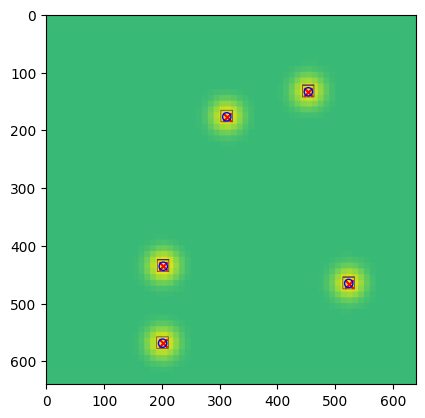

{'boxes': tensor([[19.2545, 42.5404, 21.2545, 44.5404],
        [51.3711, 45.5038, 53.3711, 47.5038],
        [30.2528, 16.6587, 32.2528, 18.6587],
        [19.1373, 55.8609, 21.1373, 57.8609],
        [44.3642, 12.3275, 46.3642, 14.3275]]), 'labels': tensor([1, 1, 1, 1, 1]), 'positions': tensor([[20.2545, 43.5404],
        [52.3711, 46.5038],
        [31.2528, 17.6587],
        [20.1373, 56.8609],
        [45.3642, 13.3275]]), 'subpixel_positions': tensor([[0.2545, 0.5404],
        [0.3711, 0.5038],
        [0.2528, 0.6587],
        [0.1373, 0.8609],
        [0.3642, 0.3275]])}
{'boxes': tensor([[44.3700, 12.2832, 46.3551, 14.3241],
        [19.1424, 55.8205, 21.1169, 57.8555],
        [19.2535, 42.4982, 21.2282, 44.5330],
        [30.2374, 16.6307, 32.2346, 18.6506],
        [51.3510, 45.4712, 53.3526, 47.5069]]), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000]), 'box_centers': tensor([[45.3626, 13.3037],
        [20.1296, 56.8380],
      

In [26]:
model.to(device='cuda')
device = 'cuda'
model.eval()
img, tar = valid_dataset[2]
img = move_data_to_device(img,device)
tar = move_data_to_device(tar,device)
imgs = []
imgs.append(img)
with torch.no_grad():
  out = model(imgs)

out = out[0]
move_dict_to_cpu(tar)
move_dict_to_cpu(out)
plot_image_boxes(img,tar,out,True,True)
print(tar)
print(out)

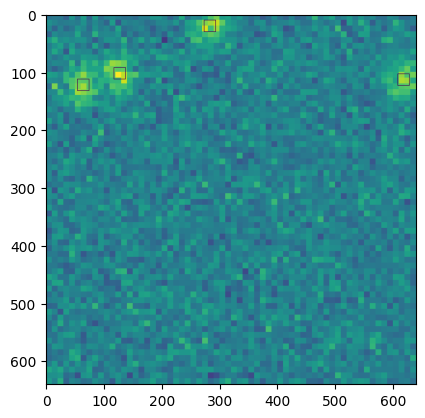

In [21]:
i, t = valid_dataset[0]
plot_image_boxes(i,t,None,True,False)